In [1]:
import os
import h5py
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import shape, LineString
from modis_utils.misc import restore_data
from skimage import io, img_as_bool, measure, morphology
from scipy import ndimage
from scipy.ndimage import measurements

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras.models import Input, Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras.optimizers import adam, SGD

#  Params

In [3]:
plt.rcParams['figure.figsize'] = (20,8)

In [4]:
train_years = list(range(2002,2012))
val_years = list(range(2012,2015))
test_years = list(range(2015,2018))

data_dir = '../groundtruth_mask_lake/ALL/0'
modis_product = 'ALL'
day_period = 8 if modis_product == 'ALL' else 16

# End Params

# Util Functions

In [5]:
def find_boundaries_1(img):
    img1 = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
    img1[1:-1, 1:-1] = img
    boundary = find_boundaries(img1)
    return boundary[1:-1, 1:-1]

def calc_angle(x, y, x0, y0):
    if y == y0:
        alpha = 0 if x >= x0 else 180
        return alpha
    tan_alpha = np.abs((1.0*(x - x0)) / (1.0*(y - y0)))
    alpha = np.arctan(tan_alpha)*180/np.pi
    if x > x0:
        if y < y0:
            alpha = 180 - alpha
    else:
        if y > y0:
            alpha = 360 - alpha
        else:
            alpha = 180 + alpha
    if alpha == 360:
        alpha = 0
    return alpha

def create_two_dimension_list(n):
    res = []
    for _ in range(n):
        res.append([])
    return res

def find_largest_connected_element(lake_boundary):
    visited, label = measurements.label(lake_boundary)
    area = measurements.sum(lake_boundary, visited,
                            index = np.arange(label + 1))
    largest_element = np.argmax(area)
    return np.where(visited==largest_element, 1, 0)

# End Util Functions

In [6]:
#img = restore_data('../Zhang_mask_data/MOD13Q1/0/2000/2000049/masked.dat')
img = restore_data('../groundtruth_mask_lake/ALL/0/2005/2005177/masked.dat')

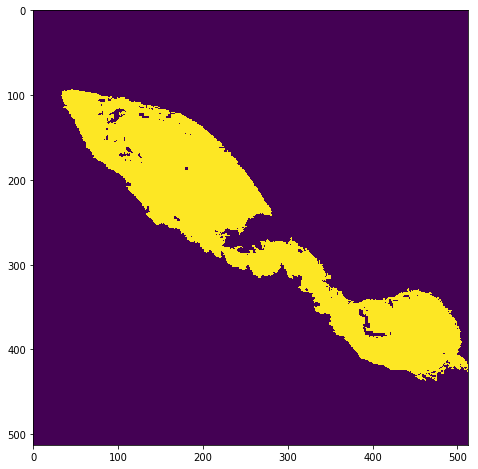

In [7]:
plt.imshow(img)

In [8]:
percentile = restore_data('percentile_0.dat')
permanent_water_pixels = np.where(percentile > 0.9, 1, 0)

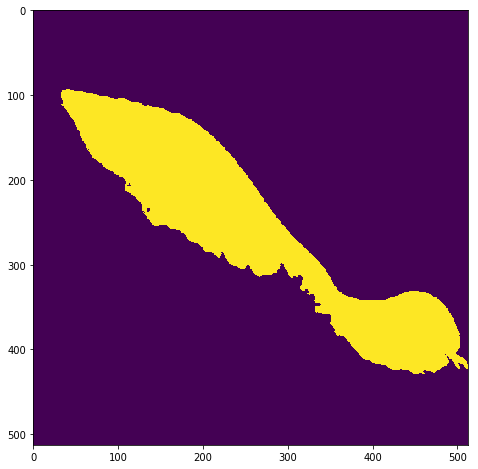

In [9]:
plt.imshow(permanent_water_pixels)

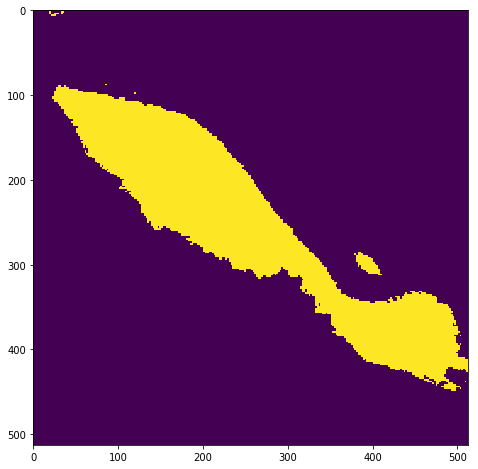

In [10]:
path_1 = '../raw_data/ALL/0/2005/2005001/MOD13Q1.A2005001.h28v07.006.2015157043612_250m_16_days_pixel_reliability.tif'
img_2 = rio.open(path_1, 'r').read(1)
reli_2 = np.where(img_2 == -1, 1, 0)
plt.imshow(reli_2)

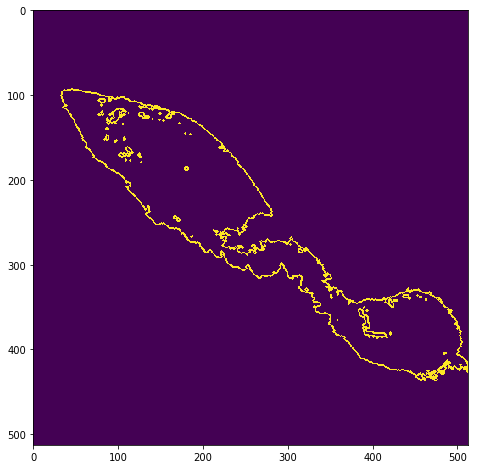

In [11]:
boundary = find_boundaries_1(img)
plt.imshow(boundary)

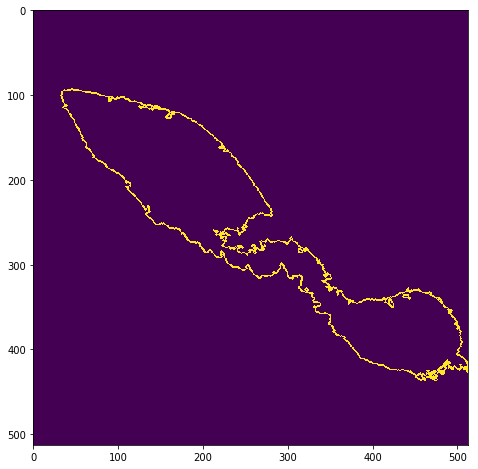

In [12]:
x = find_largest_connected_element(boundary)
plt.imshow(x)

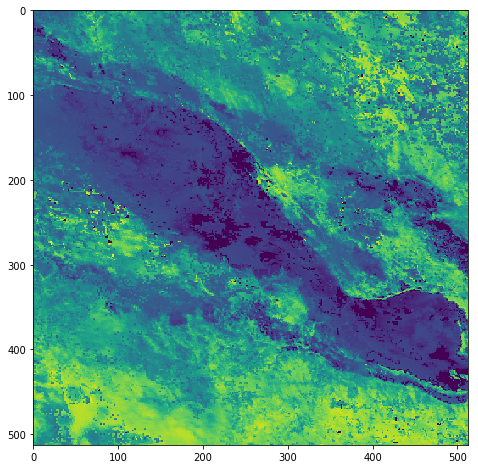

In [13]:
path = '../raw_data/MOD13Q1/0/2000/2000241/MOD13Q1.A2000241.h28v07.006.2015138080700_250m_16_days_NDVI.tif'
img_1 = rio.open(path, 'r').read(1)
plt.imshow(img_1)

# BoundaryVectorizer Class

In [14]:
def distance(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

In [15]:
import functools
def sortby(a, b):
    return (a[0] > b[0]) or (a[0] == b[0] and a[1] > b[1])

In [16]:
key = functools.cmp_to_key(sortby)

In [17]:
a = []

In [18]:
def create_empty_list(n, default_value=None):
    res = []
    for _ in range(n):
        if default_value is not None:
            res.append(default_value.copy())
    return res

In [20]:
def find_appropriate_coor(list_angles_candidates_id, diff_arr, pos):
    record = []
    for id, angle in zip(list_angles_candidates_id, diff_arr):
        record.append([angle, [pos[0][id], pos[1][id]]])
    
    distances = []
    origin = record[0][1]
    for elem in record:
        p = elem[1]
        distances.append([distance(p, origin), elem])
    distances.sort(key=key)
    
    type_id = 0
    distances[0][1].append(type_id)
    for i in range(1, len(distances)):
        if distances[i][0] - distances[i - 1][0] > 10:
            type_id += 1
        distances[i][1].append(type_id)
    
    group_by_types = create_empty_list(type_id + 1, [])
    for elem in distances:
        record_i = elem[1]
        t_id = record_i[-1]
        group_by_types[t_id].append(record_i[:-1])
    
    res = []
    for elem in group_by_types:
        elem.sort(key=key)
        res.append(elem[0][1])
    return res

In [21]:
list_angles_candidates_id = [0, 1, 2]
diff_arr = [0, 1, 0]
pos = [[200, 201, 300], [200, 200, 300]]

In [22]:
res = find_appropriate_coor(list_angles_candidates_id, diff_arr, pos)

In [23]:
res

[[200, 200], [300, 300]]

In [35]:
class BoundaryVectorizer:
    def __init__(self, n_lines, list_filenames, permanent_water_pixels):
        self.list_filenames = list_filenames
        img = restore_data(self.list_filenames[0])
        self.height, self.width = img.shape[:2]
        self.angle = np.zeros((self.height, self.width))
        self.center_x = self.height // 2
        self.center_y = self.width // 2
        self.permanent_water_pixels = permanent_water_pixels
        
        for i in range(self.height):
            for j in range(self.width):
                self.angle[i, j] = calc_angle(i, j, 256, 256)
        
        self.n_lines = n_lines
        self.len = len(list_filenames)
        self.line_angles = np.linspace(0, 360, self.n_lines + 1)[:-1]
        self.list_int_line_angles = create_two_dimension_list(360)
        for i, angle in enumerate(self.line_angles):
            self.list_int_line_angles[int(angle)].append(i)
        
        self.permanent_boundary_vector = self.get_permanent_boundary_vector()
        self.n_points = len(self.permanent_boundary_vector)
        print('n_points =', self.n_points)
        
        self.boundary_vectors = [None]*self.len
    
    
    def __len__(self):
        return self.len
    
    def get_permanent_boundary_vector(self):
        return self._vectorize_boundary_1(self.permanent_water_pixels)
    
    
    def __getitem__(self, idx):
        if self.boundary_vectors[idx] is not None:
            return self.boundary_vectors[idx]
        
        boundary_vector = self._vectorize_boundary(idx)
        try:
            assert len(boundary_vector) == len(self.permanent_boundary_vector)
            self.boundary_vectors[idx] = boundary_vector
        except:
            print(idx, len(boundary_vector))
        return boundary_vector
    
    
    def _vectorize_boundary(self, idx):
        img = restore_data(self.list_filenames[idx])
        img = np.bitwise_or(img, permanent_water_pixels)
        return self._vectorize_boundary_1(img)
    
    def _vectorize_boundary_1(self, img):
        boundary = find_boundaries_1(img)
        boundary = find_largest_connected_element(boundary)
        pos = np.where(boundary)
        list_point_angles = np.zeros(len(pos[0]))
        for i, (x, y) in enumerate(zip(*pos)):
            list_point_angles[i] = self.angle[x, y]
                
        list_int_angles_id = create_two_dimension_list(360)
        list_int_angles_value = create_two_dimension_list(360)
        for i, angle in enumerate(list_point_angles):
            list_int_angles_id[int(angle)].append(i)
            list_int_angles_value[int(angle)].append(angle)
        
        boundary_vector = []
        for i, line_angle in enumerate(self.line_angles):
            int_line_angle = int(line_angle)

            list_angles_candidates_id = list_int_angles_id[int_line_angle]
            list_angles_candidates_value = list_int_angles_value[int_line_angle]
            if len(list_angles_candidates_id) == 0:
                continue
            list_angles_candidates_value = np.asarray(list_angles_candidates_value)
            
            if len(list_angles_candidates_id) > 1:
                diff_arr = np.abs(list_angles_candidates_value - line_angle)
                boundary_vector += find_appropriate_coor(list_angles_candidates_id, diff_arr, pos)
            else:
                point_idx = list_angles_candidates_id[0]
                boundary_vector += [pos[0][point_idx], pos[1][point_idx]]
        return boundary_vector
        
    def get_boundary_vectors(self):
        for i in range(len(self.boundary_vectors)):
            if self.boundary_vectors[i] is None:
                self.boundary_vectors[i] = self.__getitem__(i)
        return np.asarray(self.boundary_vectors)

# End BoundaryVectorizer Class

In [18]:
'''
list_filenames = ['../MODIS_2/groundtruth_mask_lake/MOD13Q1/0/NDVI/normalized_div/2000/2000241/masked.dat']
boundary_vectorizer = BoundaryVectorizer(360, list_filenames)
res = boundary_vectorizer[0]
img = restore_data(list_filenames[0])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(img)
patches = []
for x, y in res:
    line_string = LineString([(256, 256), (y,x)])
    p = shape(line_string)
    p = p.buffer(0.05)
    patches.append(PolygonPatch(p, ec='aqua', zorder=1))
p = PatchCollection(patches, match_original=True)
ax.add_collection(p)
ax.axis('off')
plt.show()
'''

"\nlist_filenames = ['../MODIS_2/groundtruth_mask_lake/MOD13Q1/0/NDVI/normalized_div/2000/2000241/masked.dat']\nboundary_vectorizer = BoundaryVectorizer(360, list_filenames)\nres = boundary_vectorizer[0]\nimg = restore_data(list_filenames[0])\n\nfig, ax = plt.subplots(1,1, figsize=(10,10))\nax.imshow(img)\npatches = []\nfor x, y in res:\n    line_string = LineString([(256, 256), (y,x)])\n    p = shape(line_string)\n    p = p.buffer(0.05)\n    patches.append(PolygonPatch(p, ec='aqua', zorder=1))\np = PatchCollection(patches, match_original=True)\nax.add_collection(p)\nax.axis('off')\nplt.show()\n"

In [25]:
train_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                        for year in train_years for day in range(1,366, day_period)]
train_list_filenames = list(filter(lambda x: os.path.isfile(x), train_list_filenames))

val_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                      for year in val_years for day in range(1,366, day_period)]

test_list_filenames = [os.path.join(data_dir, str(year), '{}{:03}'.format(year, day), 'masked.dat')
                       for year in test_years for day in range(1,366, day_period)]

In [26]:
os.path.isfile(train_list_filenames[0])

True

In [27]:
train_list_filenames[0]

'../groundtruth_mask_lake/ALL/0/2002/2002177/masked.dat'

In [22]:
'''
if h5file is not None:
    train_boundary_vectors = h5file['train']
    val_boundary_vectors = h5file['val']
    test_boundary_vectors = h5file['test']
else:
'''

"\nif h5file is not None:\n    train_boundary_vectors = h5file['train']\n    val_boundary_vectors = h5file['val']\n    test_boundary_vectors = h5file['test']\nelse:\n"

In [36]:
train_boundary_vectorizer = BoundaryVectorizer(1024, train_list_filenames, permanent_water_pixels)
val_boundary_vectorizer = BoundaryVectorizer(1024, val_list_filenames, permanent_water_pixels)
test_boundary_vectorizer = BoundaryVectorizer(1024, test_list_filenames, permanent_water_pixels)

train_boundary_vectors = train_boundary_vectorizer.get_boundary_vectors()
val_boundary_vectors = val_boundary_vectorizer.get_boundary_vectors()
test_boundary_vectors = test_boundary_vectorizer.get_boundary_vectors()

if not os.path.exists('cache'):
    os.makedirs('cache')
if not os.path.isfile('cache/boundary_vectors_{}.h5'.format(modis_product)):
    h5file = h5py.File('cache/boundary_vectors_{}.h5'.format(modis_product), 'w')
    
    h5file.create_dataset('0_train', data=train_boundary_vectors)
    h5file.create_dataset('1_val', data=val_boundary_vectors)
    h5file.create_dataset('2_test', data=test_boundary_vectors)
    
    h5file.close()

n_points = 4196
n_points = 4196
n_points = 4196
0 5145
1 5332
2 5586
3 5884
4 7224
5 8756
6 8904
7 8454
8 19207
9 18630
10 15966
11 16104
12 13139
13 14097
14 8811
15 15408
16 14673
17 12207
18 10724
19 10474
20 5865
21 5588
22 5885
23 5597
24 5707
25 5862
26 5178
27 4932
28 5049
29 5123
30 4983
31 5017
32 5037
33 4632
34 4926
35 4654
36 5177
37 4487
38 4511
39 4834
40 4641
41 4609
42 4992
43 4719
44 4687
45 4742
46 4570
47 4742
48 4493
49 4790
50 5523
51 5154
52 6827
53 7718
54 6533
55 7356
56 7756
57 8537
58 7069
59 8219
60 6404
61 8077
62 6519
63 5785
64 6420
65 5466


KeyboardInterrupt: 

In [24]:
#train_boundary_vectors = train_boundary_vectorizer.get_boundary_vectors()

In [28]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL.h5'))

train_boundary_vectors = data[0]
val_boundary_vectors = data[1]
test_boundary_vectors = data[2]

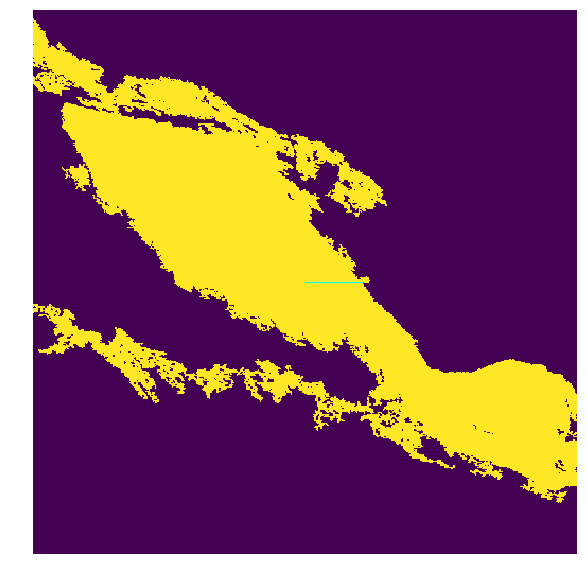

In [36]:
idx = 80
res = val_boundary_vectors[idx]
img = restore_data(val_list_filenames[idx])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(img)
patches = []
for x, y in res[:1]:
    line_string = LineString([(256, 256), (y,x)])
    p = shape(line_string)
    p = p.buffer(0.05)
    patches.append(PolygonPatch(p, ec='aqua', zorder=1))
p = PatchCollection(patches, match_original=True)
ax.add_collection(p)
ax.axis('off')
plt.show()

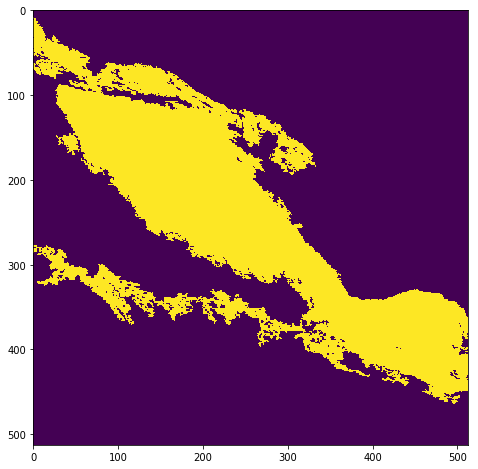

In [37]:
plt.imshow(img)

In [40]:
from scipy.ndimage import sobel

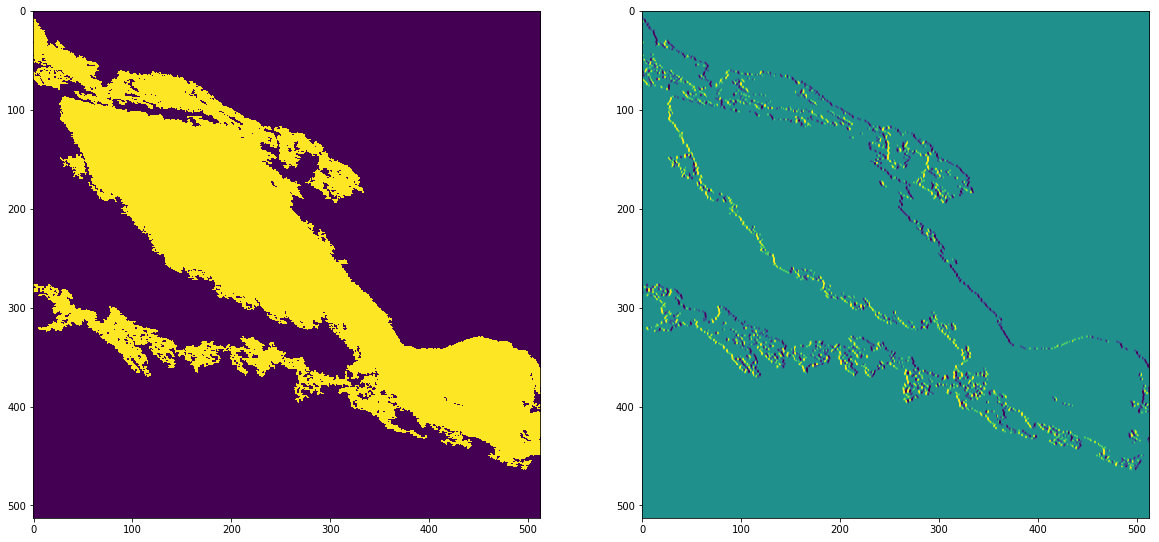

In [41]:
img_sobel = sobel(img)
fig, axes = plt.subplots(1,2,figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(img_sobel)

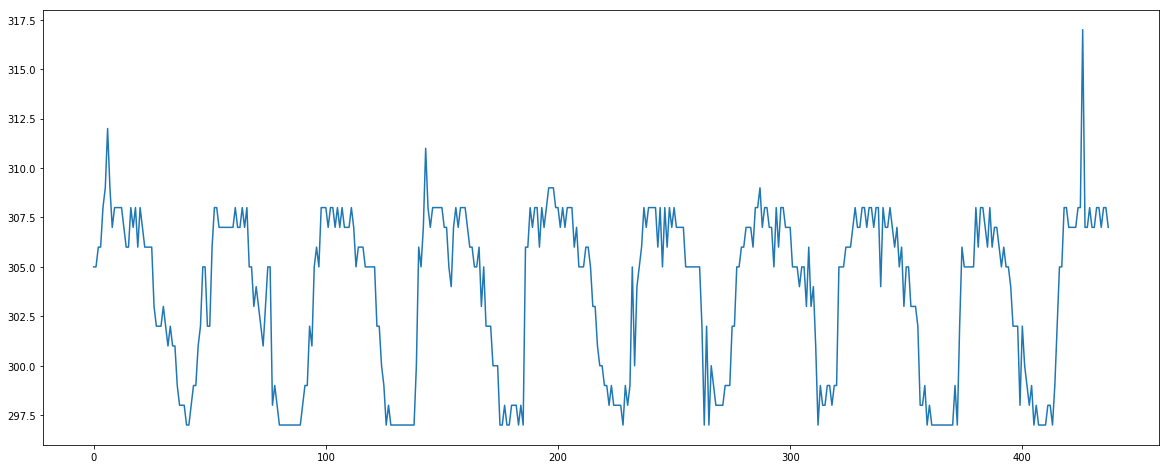

In [28]:
a = train_boundary_vectors[:,0,1]
plt.plot(a)

In [29]:
np.min(a)

297.0

In [30]:
type(train_boundary_vectors)

numpy.ndarray

In [24]:
path = '../raw_data/ALL/0/2018/2018361/MYD13Q1.A2018361.h26v05.006.2019015131739_250m_16_days_NDVI.tif'
img = rio.open(path, 'r').read(1)
img.shape

(513, 513)

In [34]:
val_boundary_vectors = val_boundary_vectorizer.get_boundary_vectors()
test_boundary_vectors = val_boundary_vectorizer.get_boundary_vectors()

In [35]:
len(train_boundary_vectors)

438

In [36]:
data = train_boundary_vectors[:,0,:]

In [37]:
data.shape

(438, 2)

In [29]:
x = data[24:]

In [30]:
x.shape

(414, 2)

In [31]:
n_couple_years = x.shape[0]//46 - 1
n_couple_years

8

In [32]:
if not os.path.exists('figs'):
    os.makedirs('figs')

In [34]:
def plot_points(line_idx):
    x = train_boundary_vectors[24:,line_idx,:]
    if len(np.unique(x[:, 0])) <= 3:
        x = x[:, 1]
    else:
        x = x[:, 0]
    n_years = x.shape[0]//46
    
    fig, ax = plt.subplots(n_years, 1, figsize=(50,n_years*10))
    plt.rcParams.update({'font.size': 22})
    
    year = 2003
    for i in range(n_years):
        data = x[i*46:(i + 1)*46]
        zs = np.arange(data.shape[0])
        ax[i].plot(zs, data)

        ax[i].set_ylabel('Y', fontsize=22)
        ax[i].set_xlabel('Time', fontsize=22)
        ax[i].set_title('Year {}'.format(year), color='red')
        
        year += 1

    fig.savefig('figs/{}.png'.format(line_idx))
    plt.show()
    #plt.savefig('figs/{}.png'.format(line_idx))

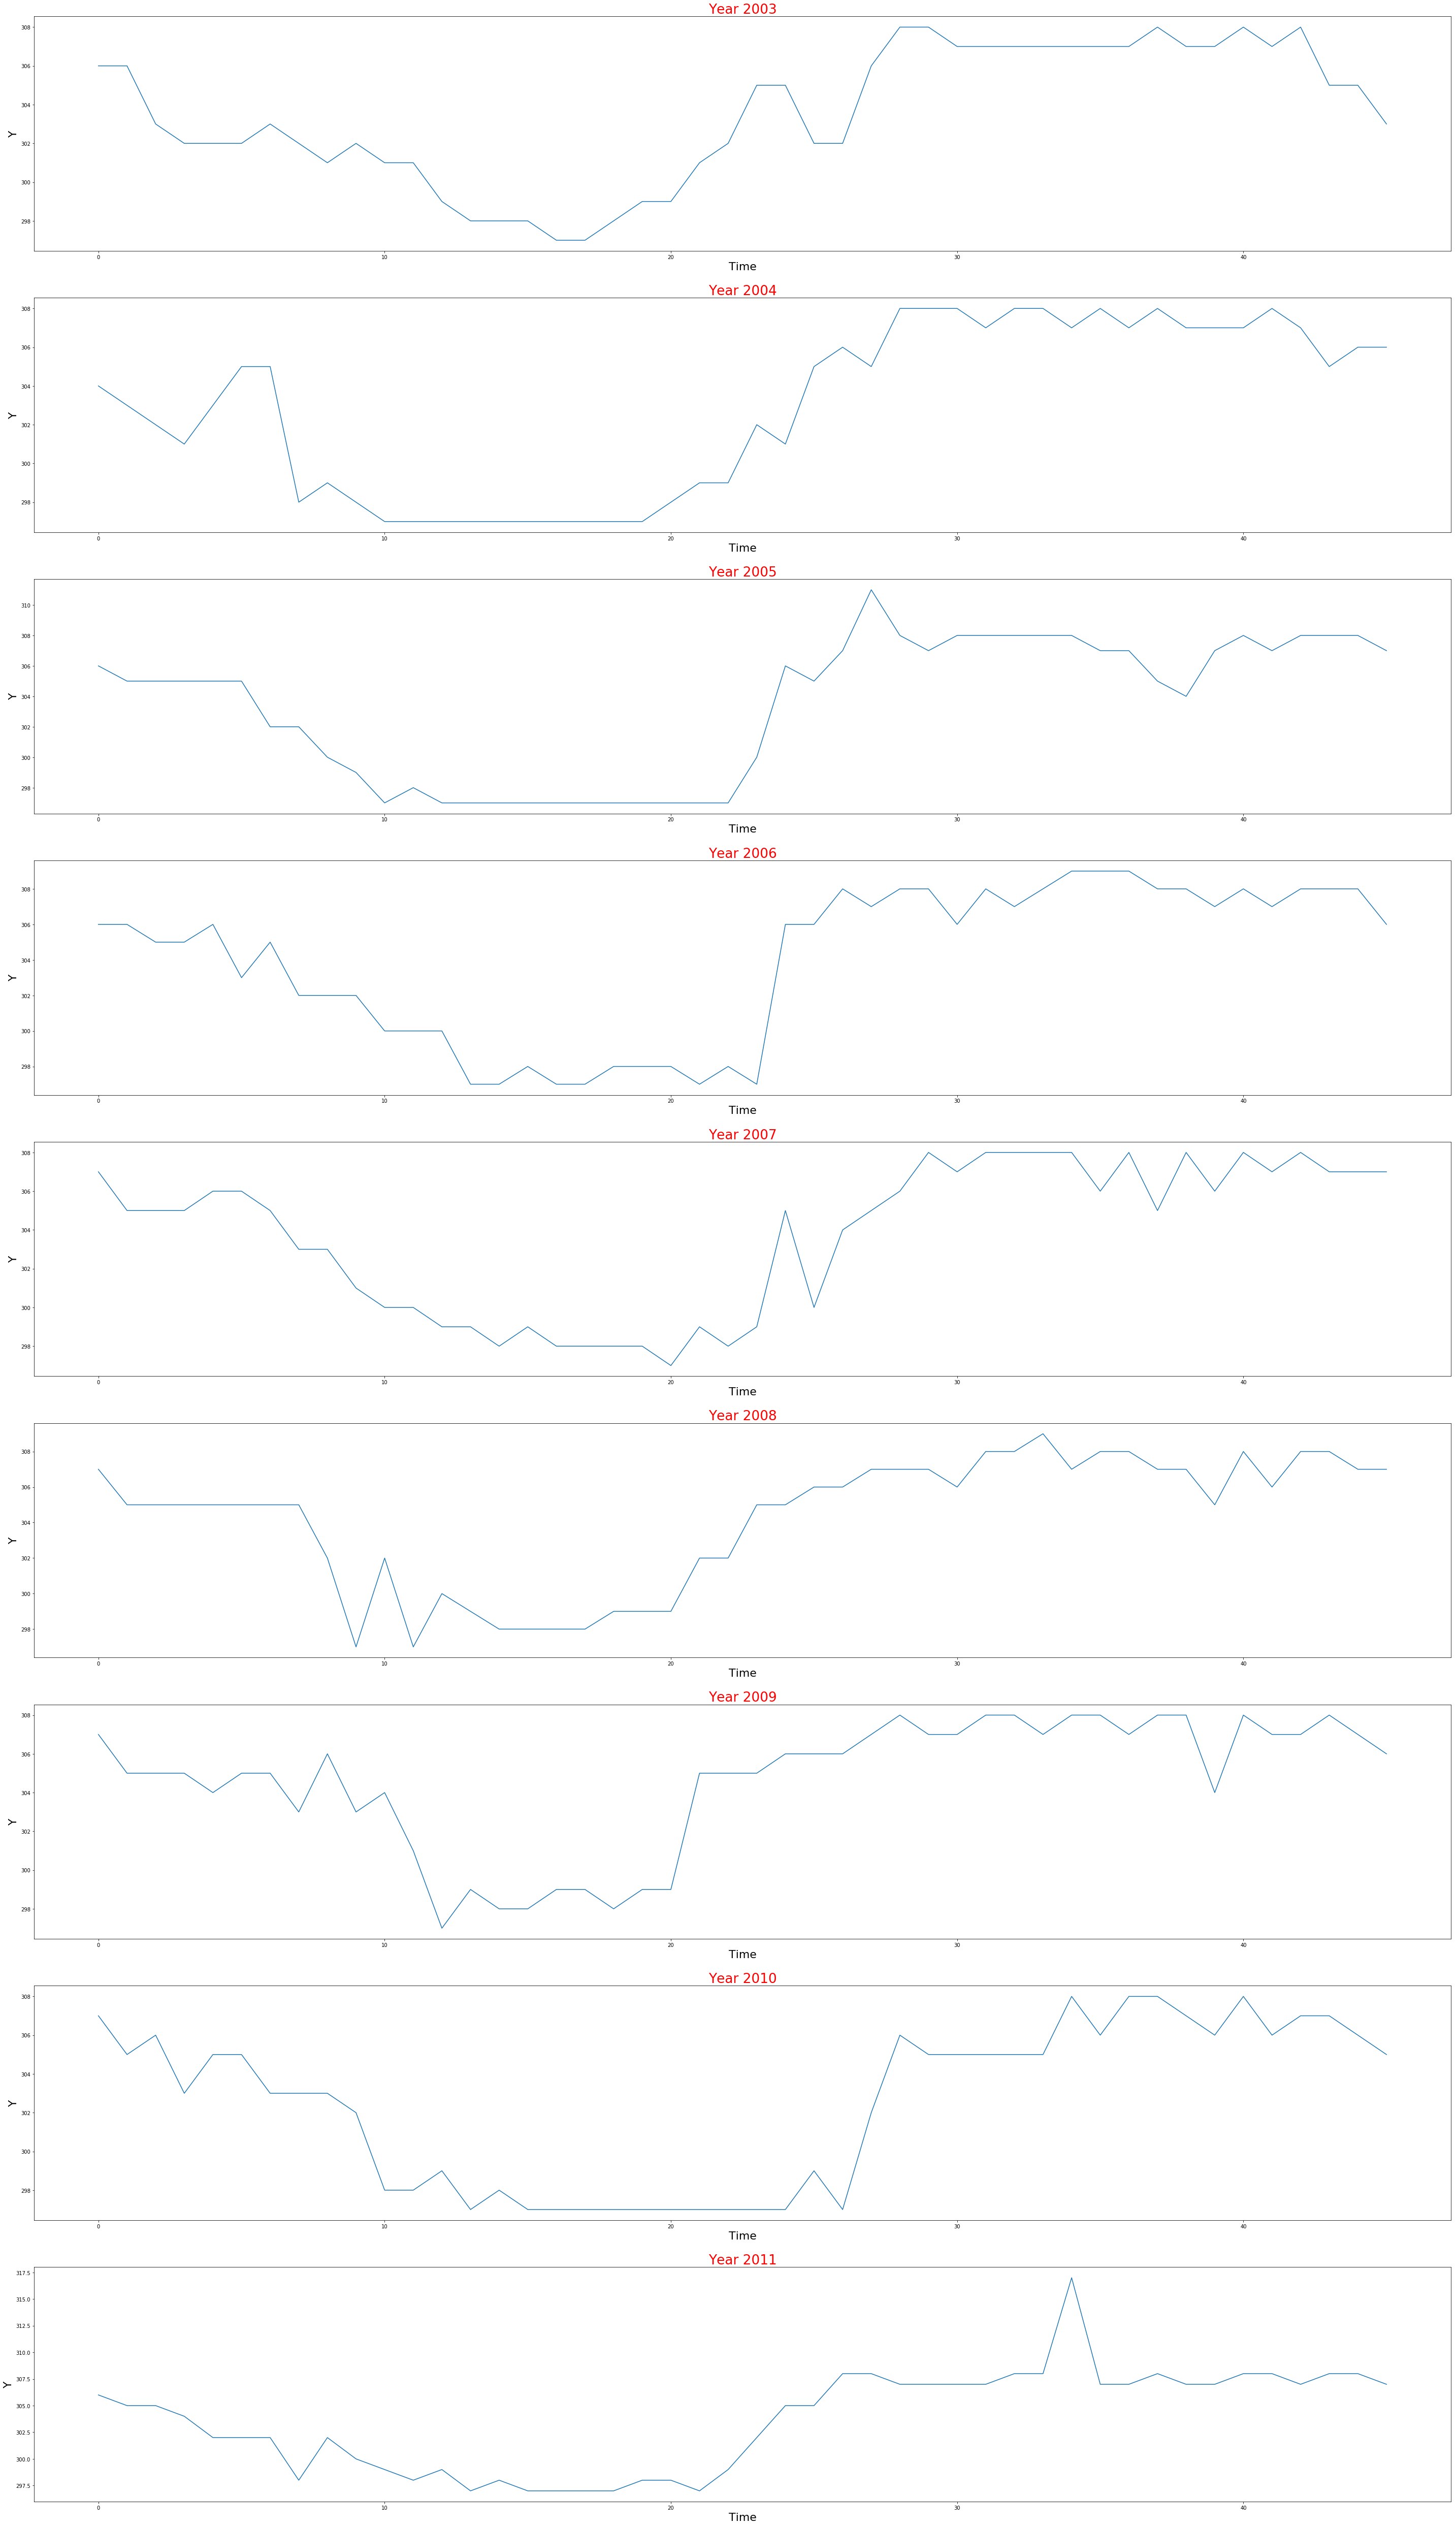

In [35]:
plot_points(line_idx=0)

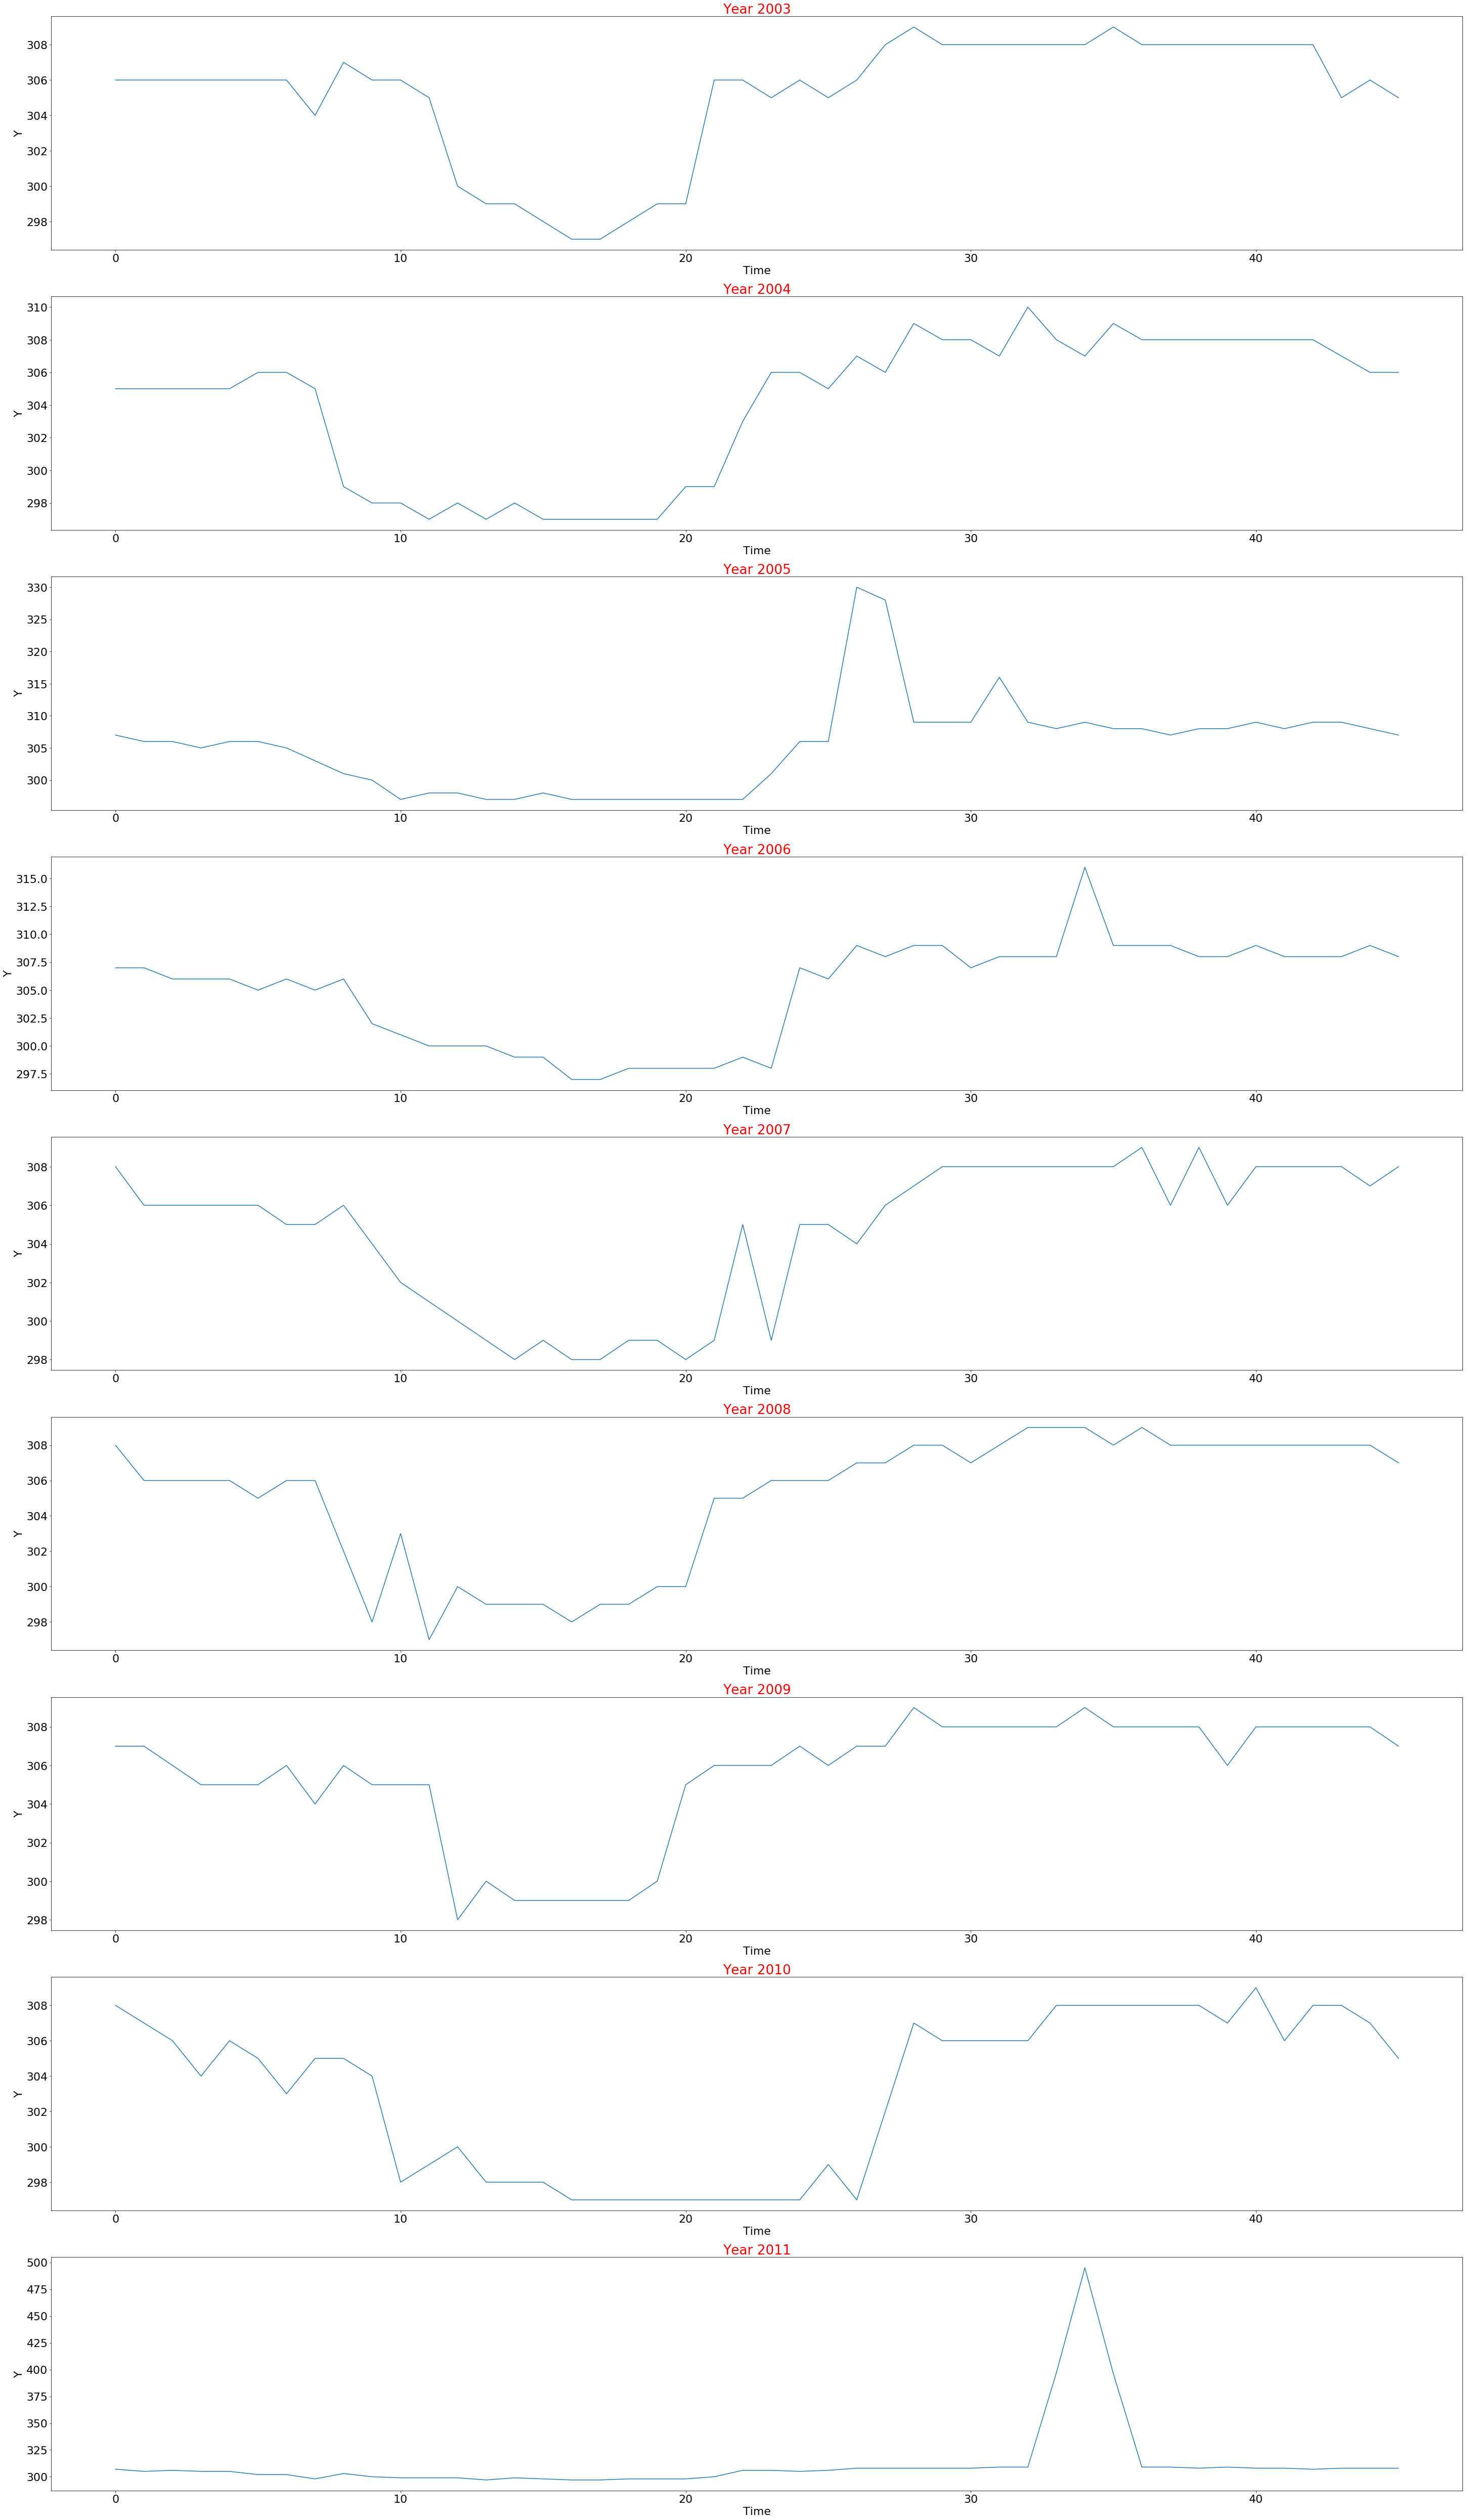

In [36]:
plot_points(line_idx=1023)

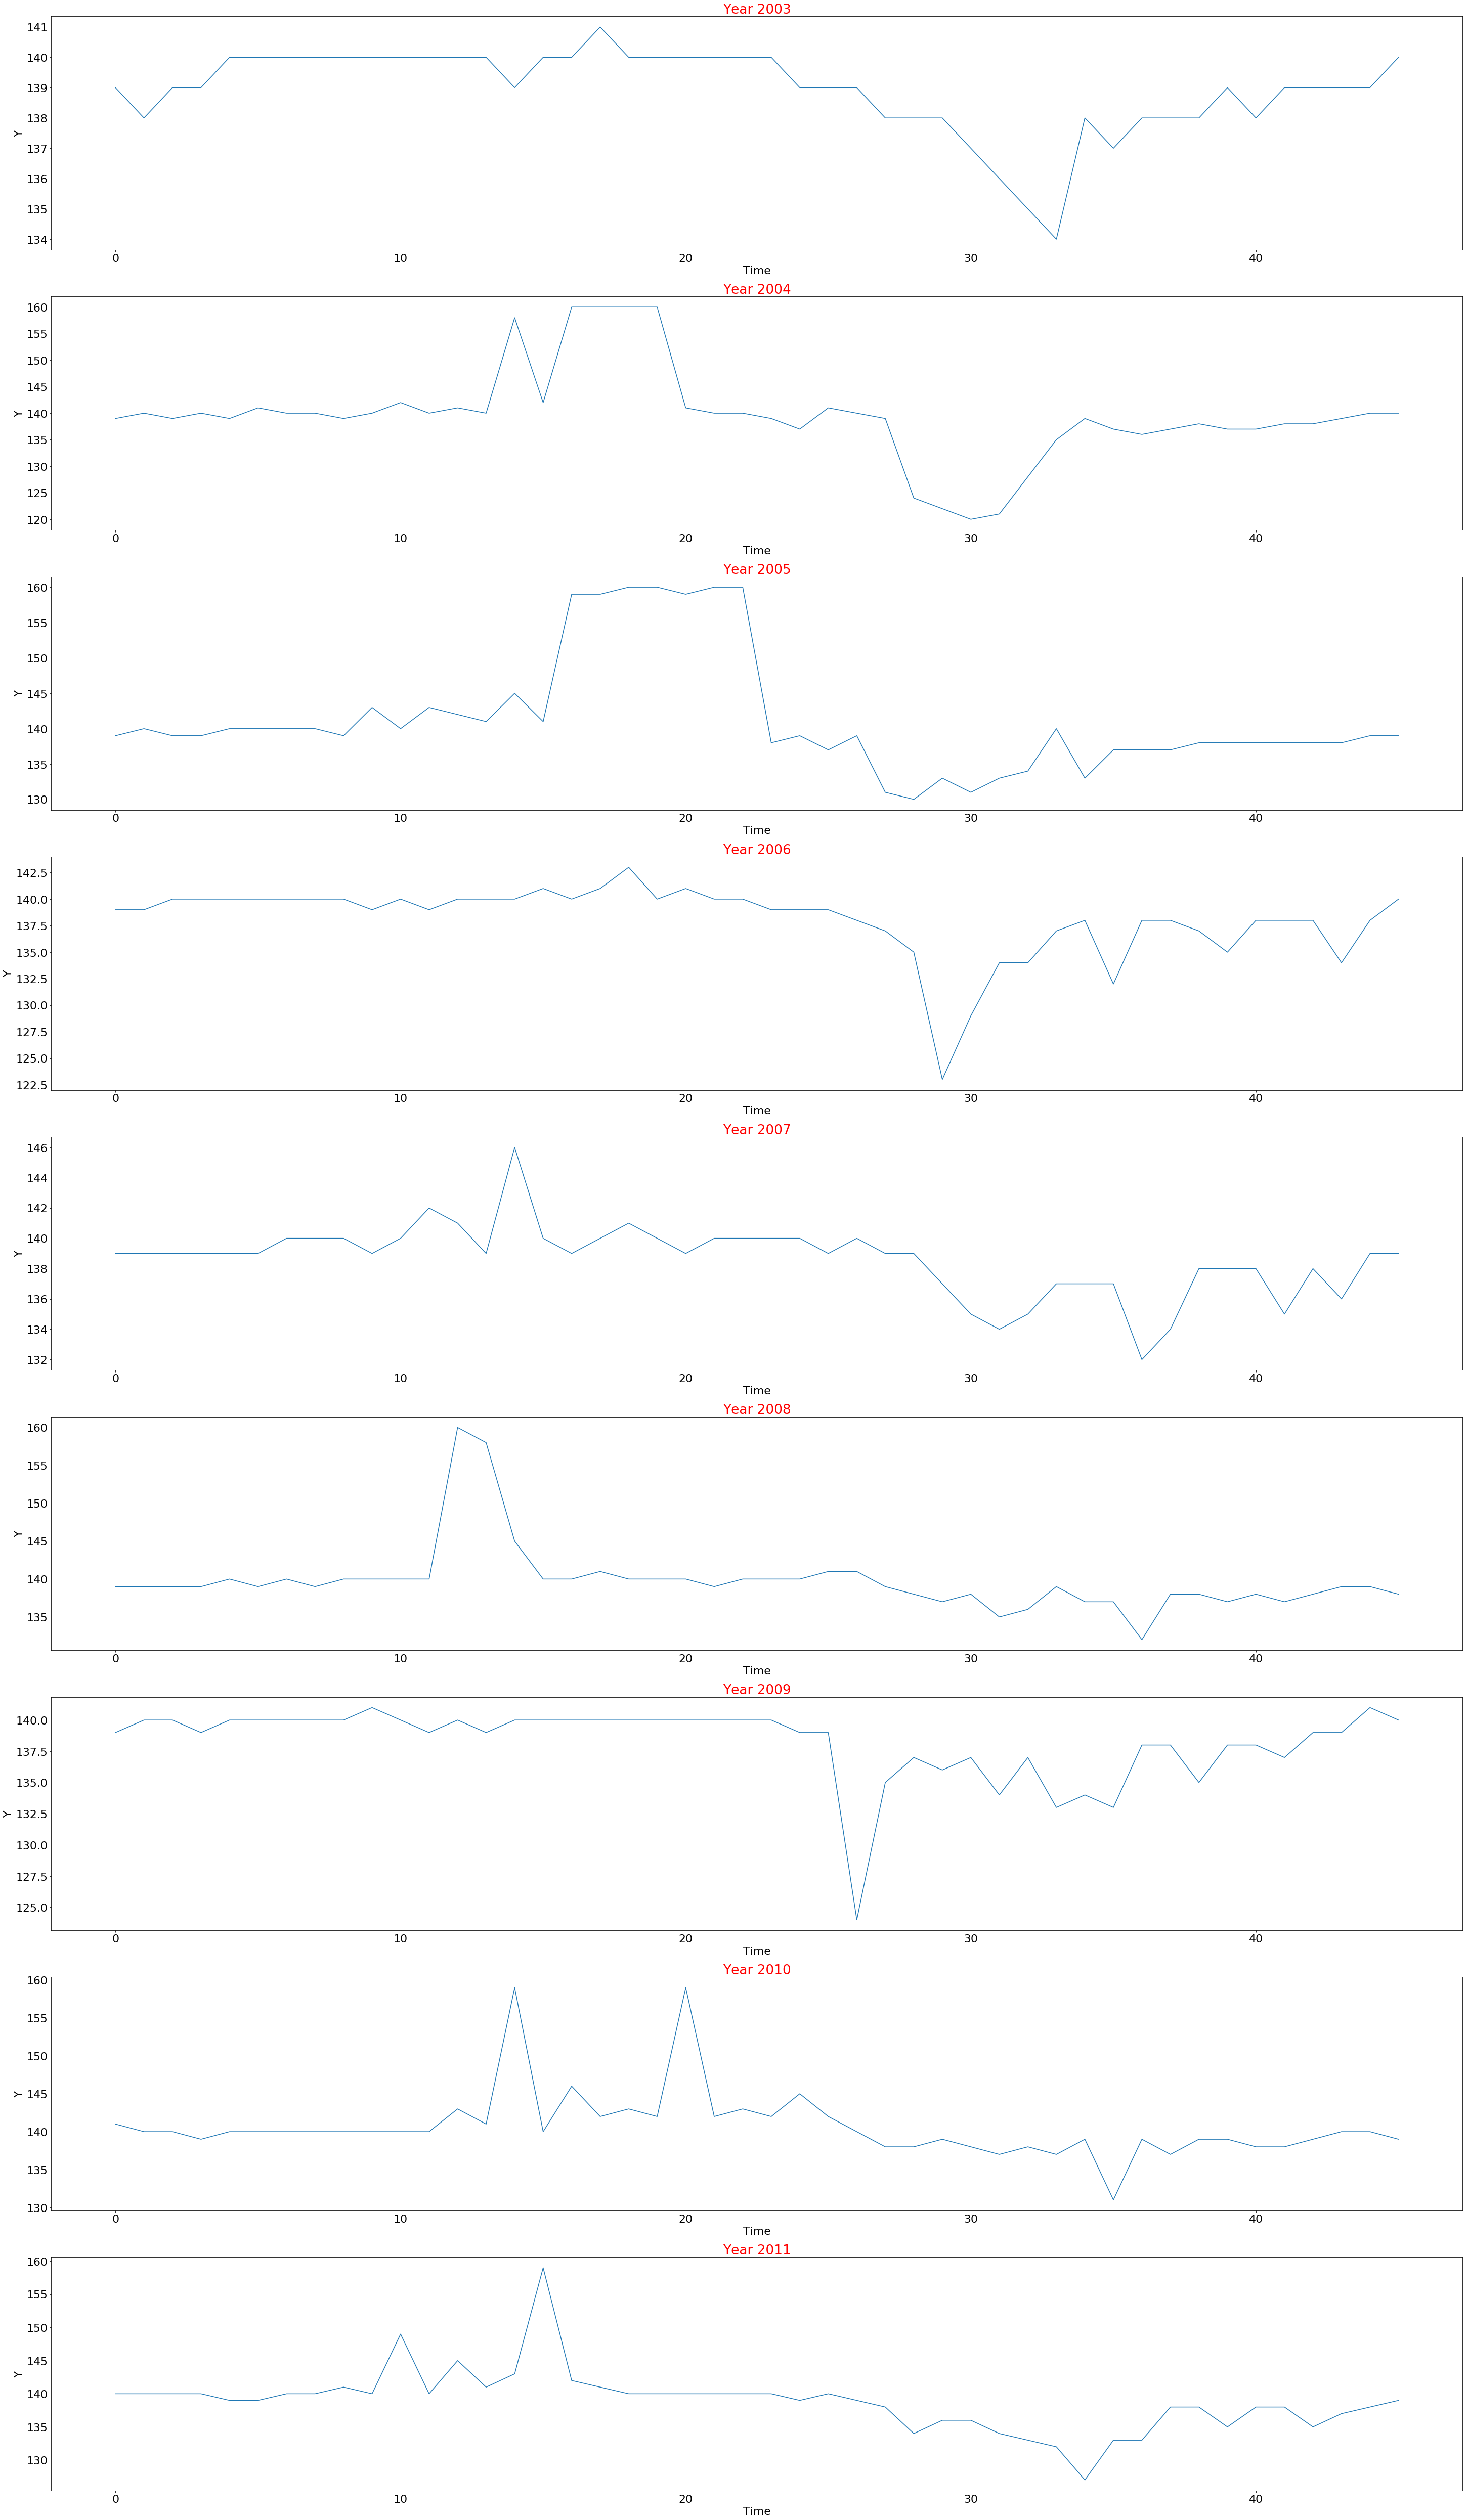

In [37]:
plot_points(line_idx=511)

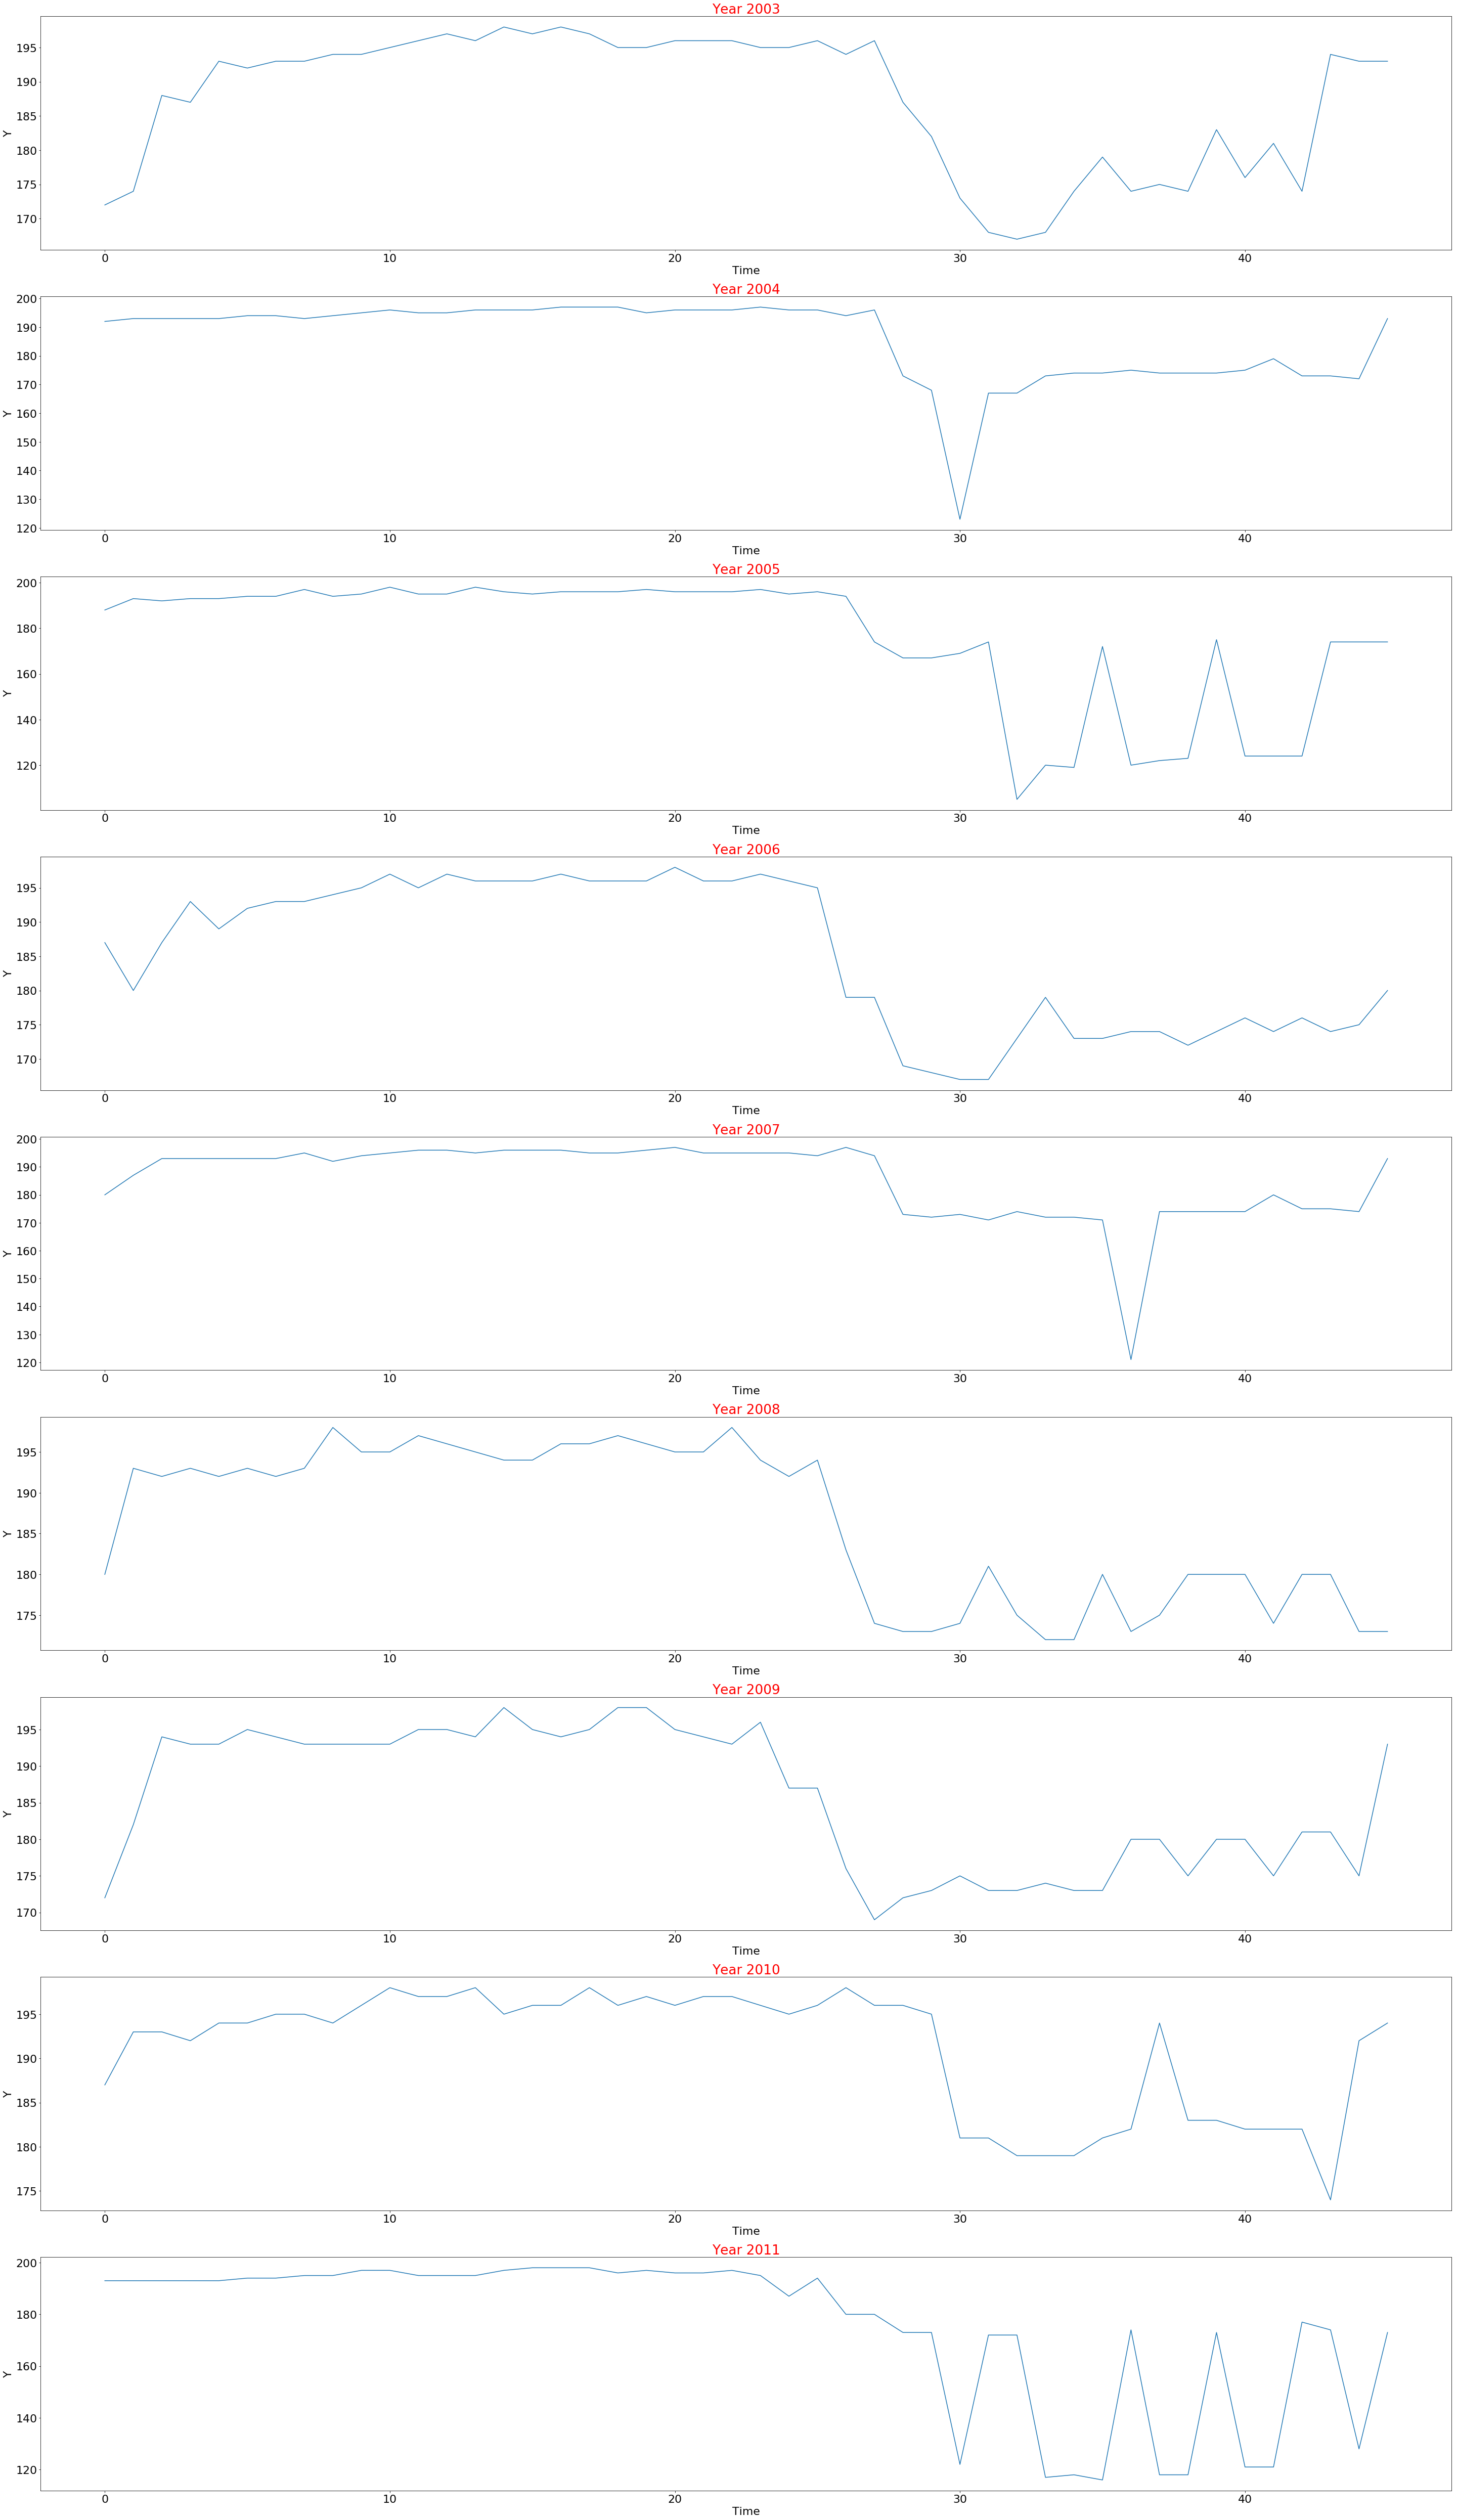

In [38]:
plot_points(line_idx=768)

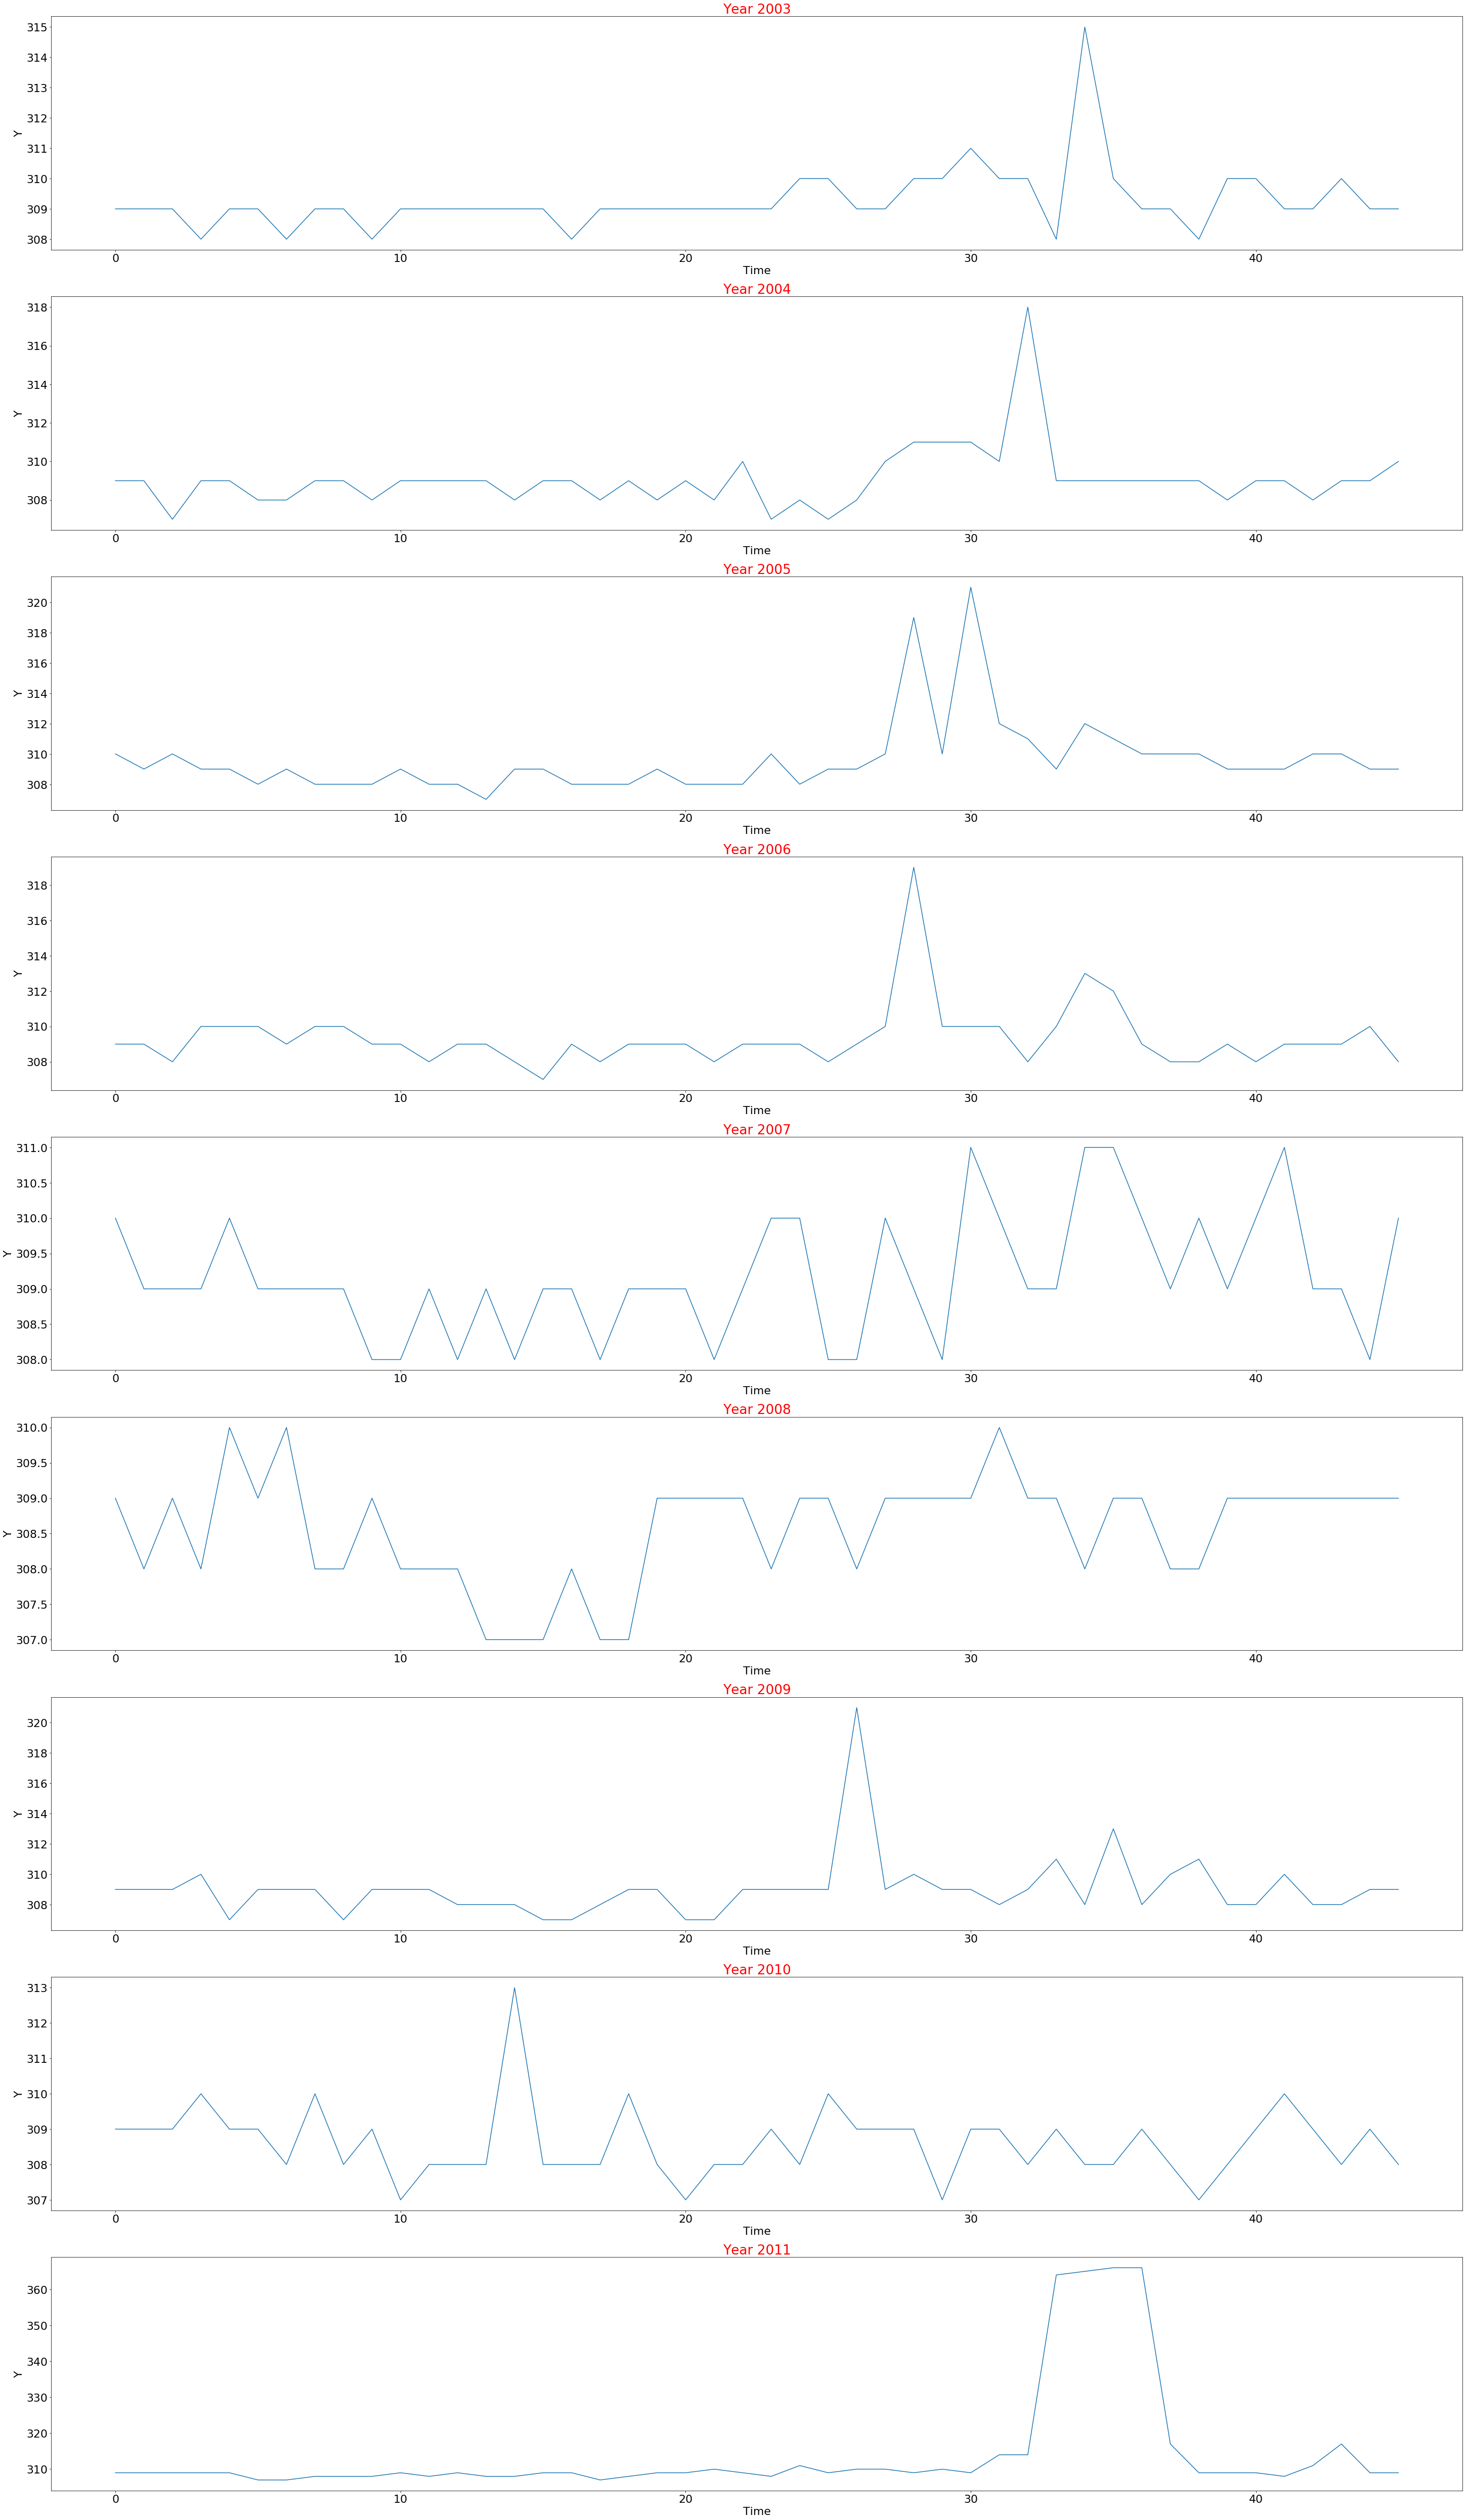

In [39]:
plot_points(line_idx=255)

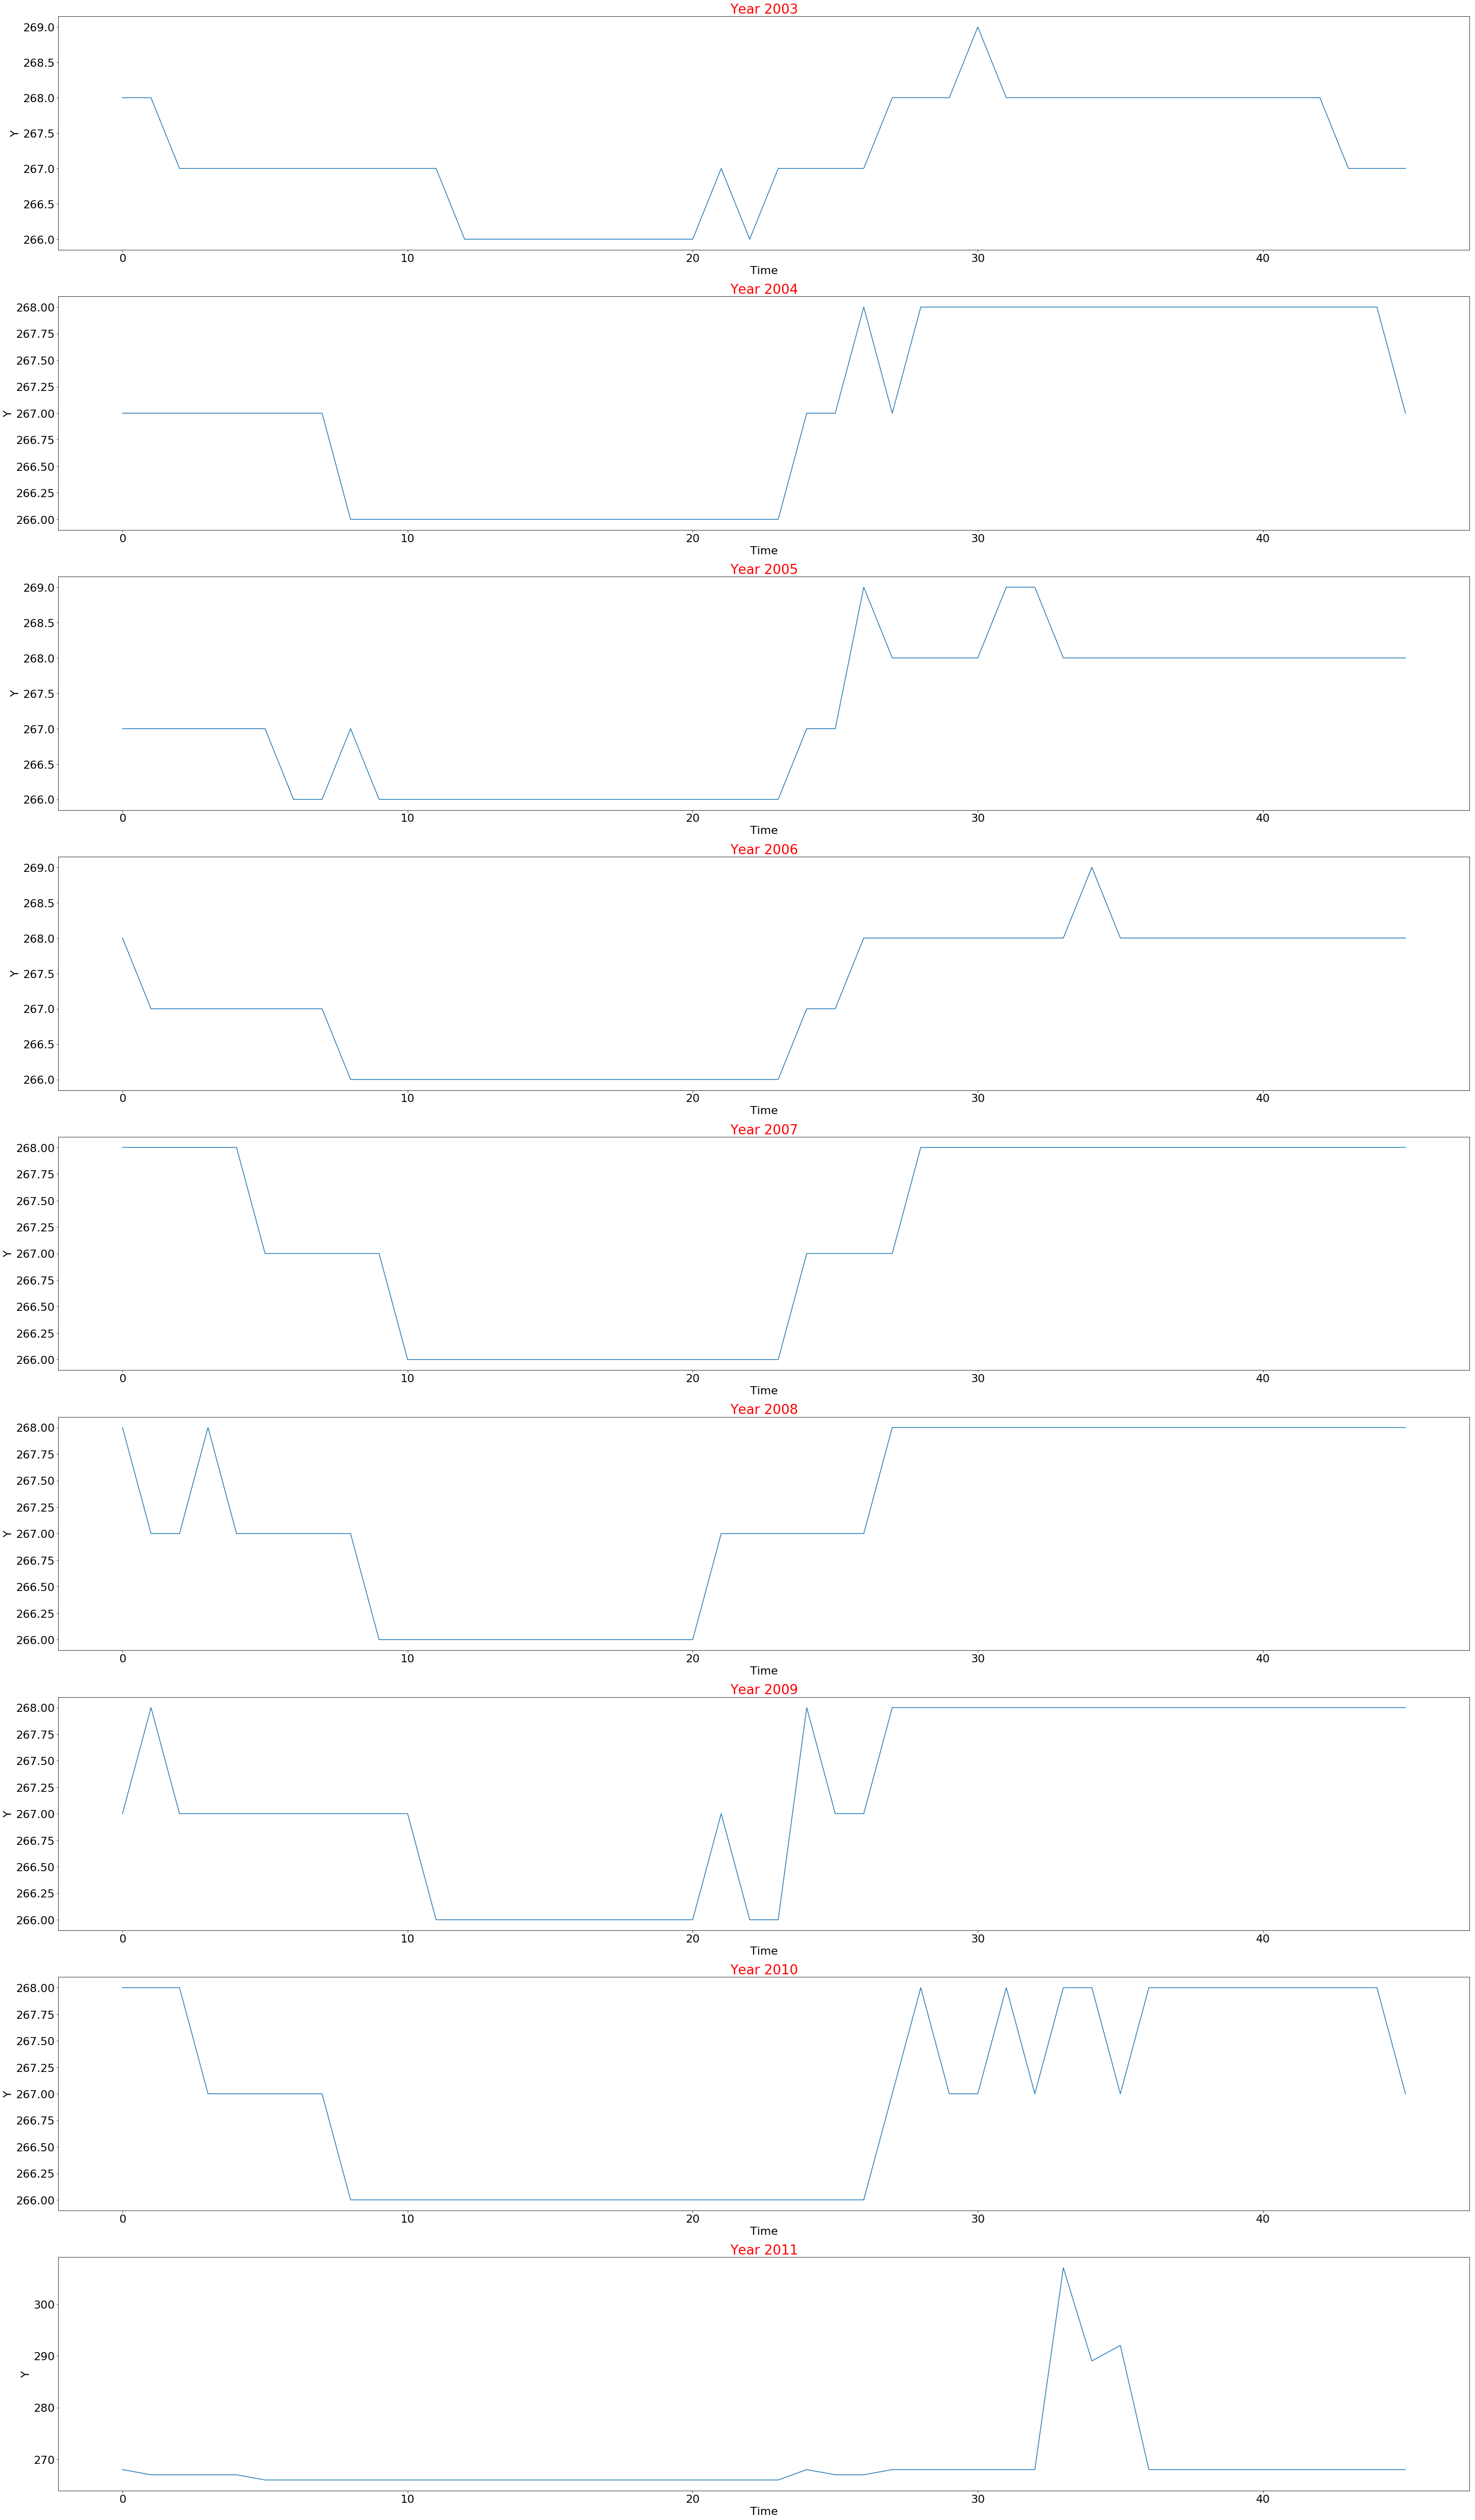

In [40]:
plot_points(line_idx=32)

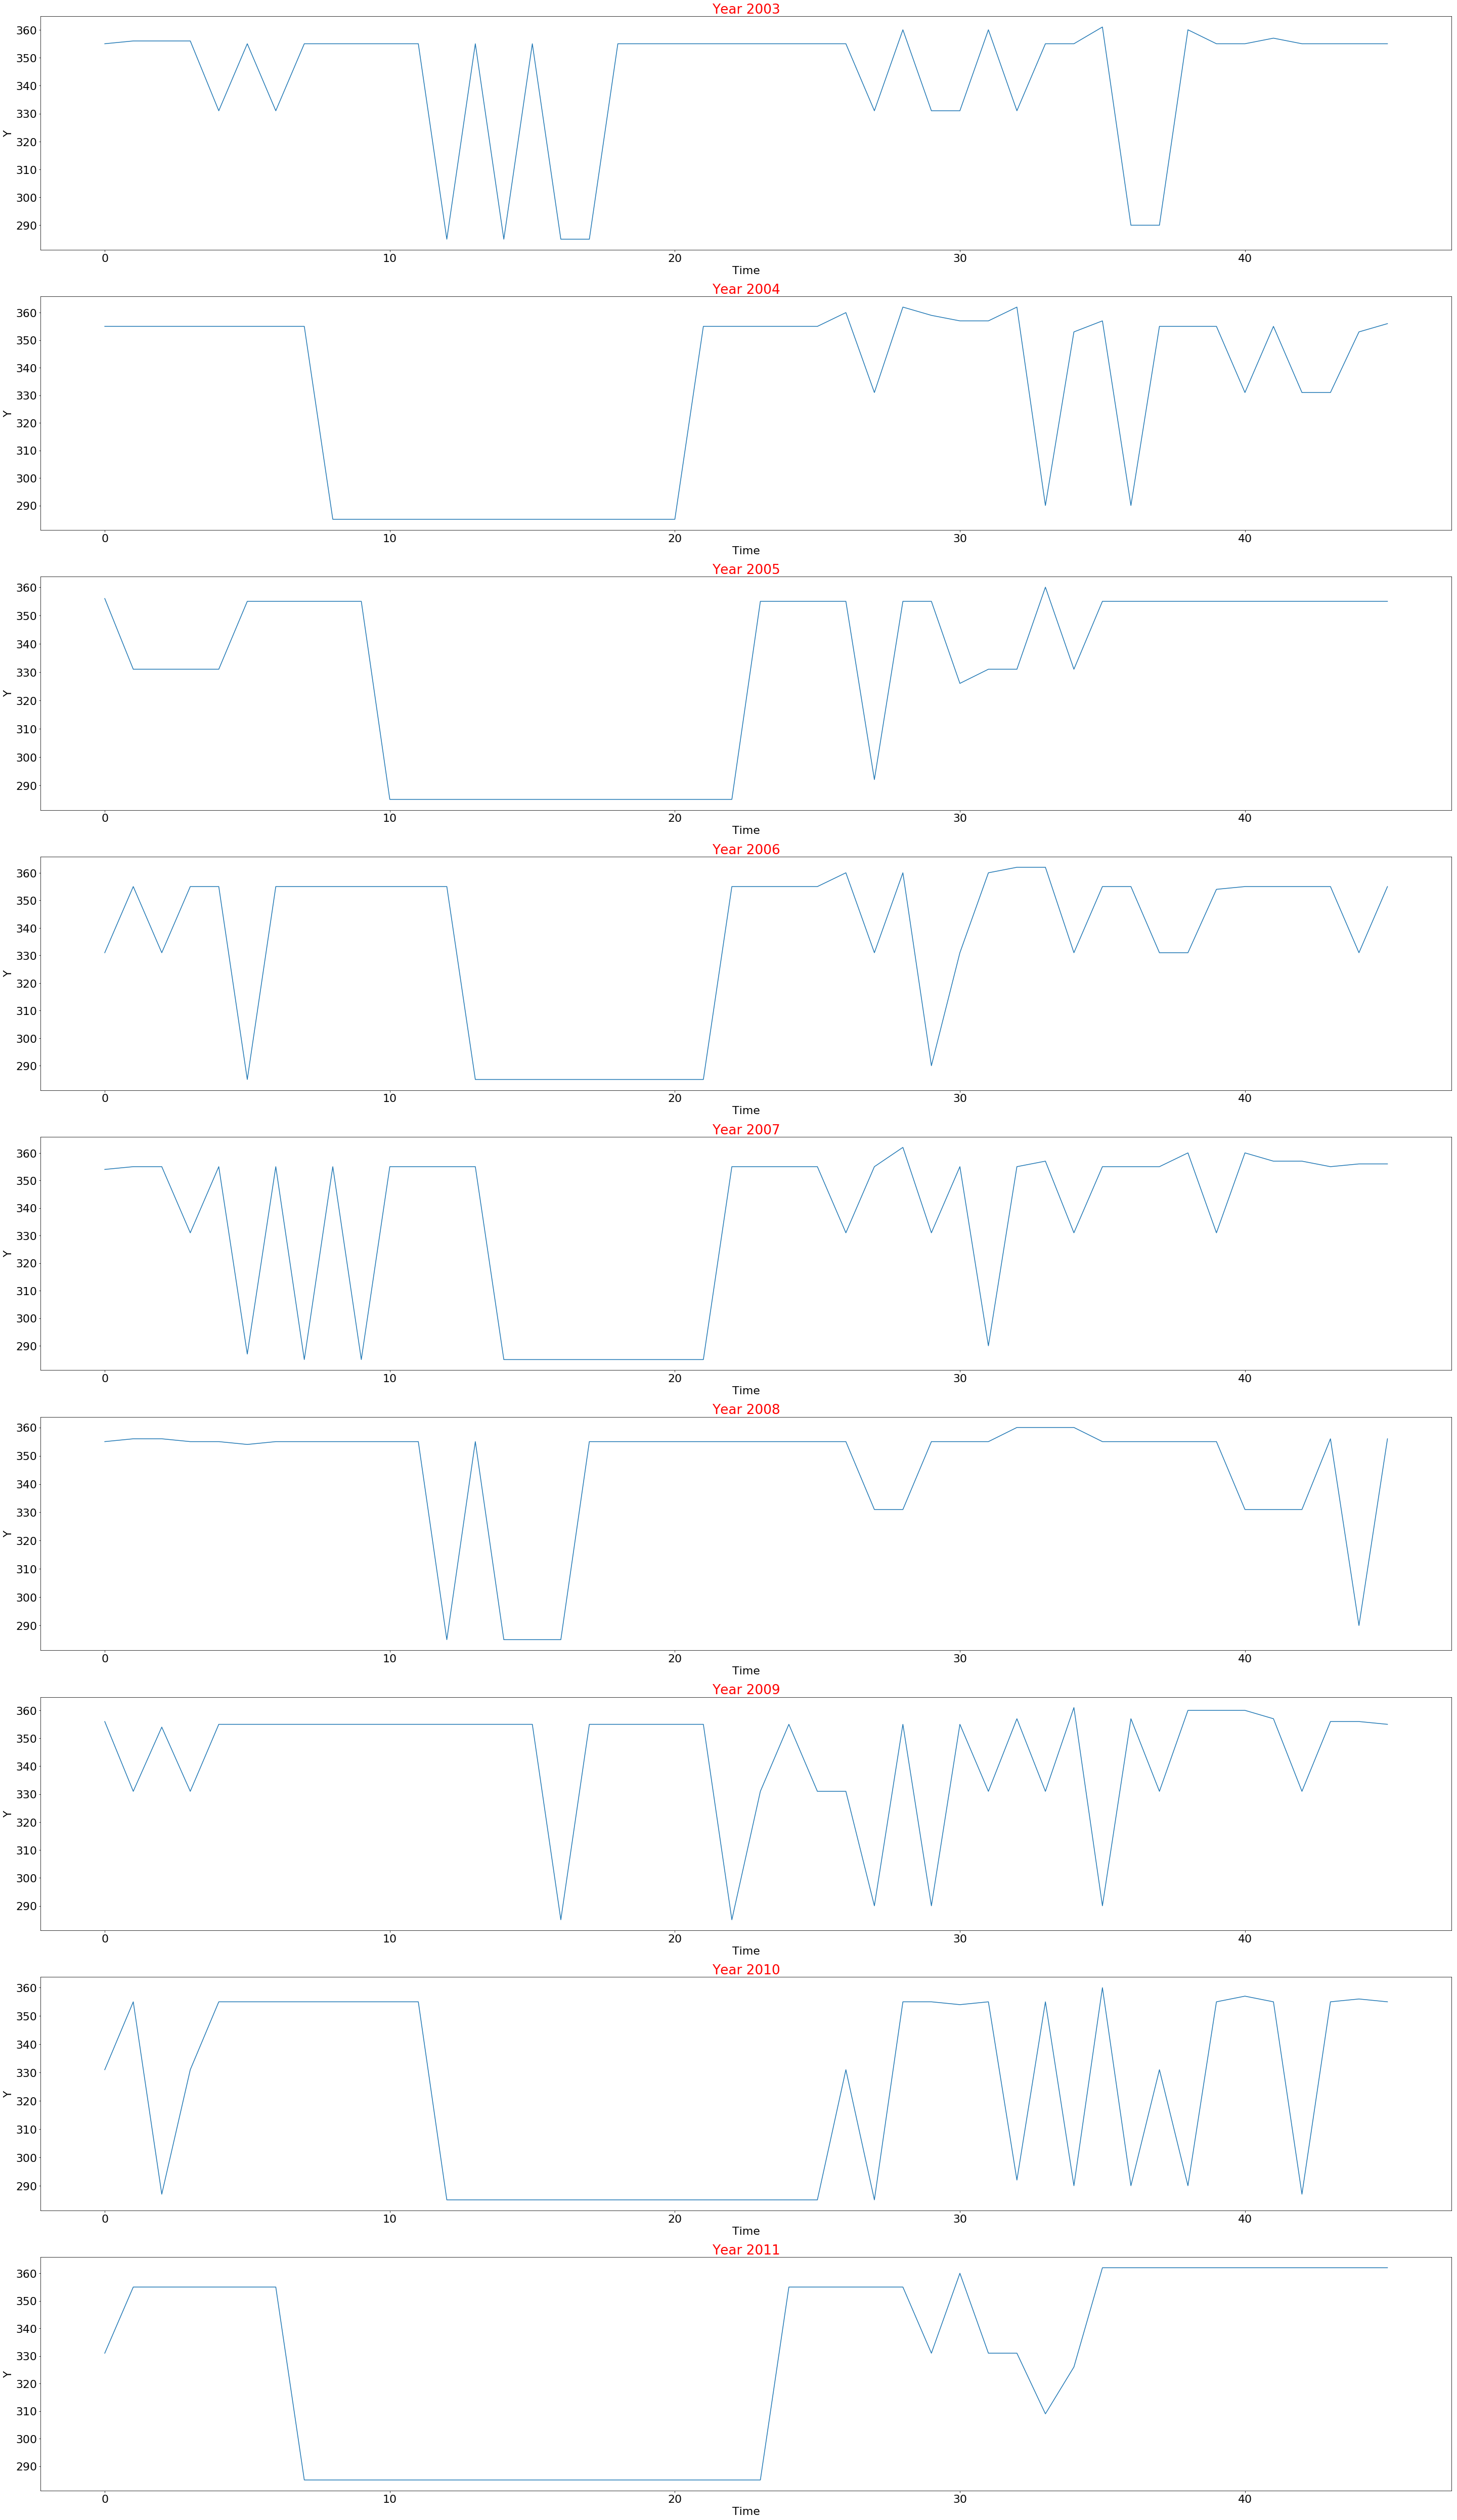

In [41]:
plot_points(line_idx=64)

In [13]:
data1['train']

<HDF5 dataset "train": shape (438, 1024, 2), type "<f8">